In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import sklearn as sk

# GPU Setup

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable first GPU
  tf.config.set_visible_devices(physical_devices[:-1], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  # Logical device was not created for first GPU
  assert len(logical_devices) == len(physical_devices) - 1
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Data preprocessing

In [3]:
# Build dataset
# python -m tensorflow_datasets.scripts.download_and_prepare --datasets=mri_dataset --module_import=mri_dataset --manual_dir=../../data/mri_dataset

In [4]:
import tensorflow_datasets as tfds
from datasets.mri_dataset import MriDataset
from tensorflow.data import Dataset


data_folder = 'data'
dataset = 'mri_dataset'
train_label = 'train_label.csv'
train_folder = 'train'
test_folder = 'test'


TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
IMG_SIZE = (512, 512)
SEED = 0


num_classes = 3
train_folds = tfds.load(
    name='mri_dataset', 
    split=[f'train[:{k}%]+train[{k+10}%:]' for k in range(0, 100, 10)], # 'train[:90%]' 
    download=False, 
    shuffle_files=False, 
    as_supervised=True
)
valid_folds = tfds.load(
    name='mri_dataset', 
    split=[f'train[{k}%:{k+10}%]' for k in range(0, 100, 10)], # 'train[:-10%]' 
    download=False, 
    shuffle_files=False, 
    as_supervised=True
)
test_ds, test_info = tfds.load(name='mri_dataset', split='test', download=False, shuffle_files=False, as_supervised=False, with_info=True)

train_folds = [ ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))).batch(TRAIN_BATCH_SIZE) for ds in train_folds ]
valid_folds = [ ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))).batch(VALID_BATCH_SIZE) for ds in valid_folds ]

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_folds = [ ds.prefetch(buffer_size=AUTOTUNE) for ds in train_folds ]
valid_folds = [ ds.prefetch(buffer_size=AUTOTUNE) for ds in valid_folds ]
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

train_ds = train_folds[0]
valid_ds = valid_folds[0]

In [5]:
train_valid_df = pd.read_csv(os.path.join(data_folder, dataset, train_label))
print(f'Number of train batches: {train_ds.cardinality()}')
print(f'Number of valid batches: {valid_ds.cardinality()}')
print(f'Number of test batches: {test_ds.cardinality()}')

Number of train batches: 33
Number of valid batches: 4
Number of test batches: 292


/home/zongsien/MedicalImageClassifier/env/lib/python3.7/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


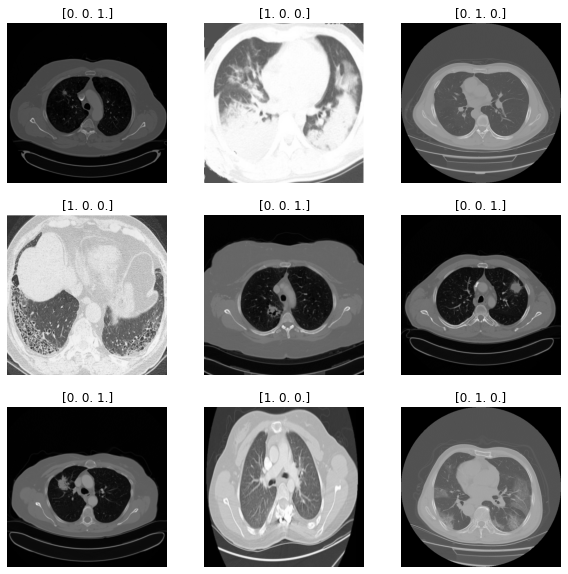

In [6]:
# Train Data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(labels[i].numpy())
      plt.axis("off")

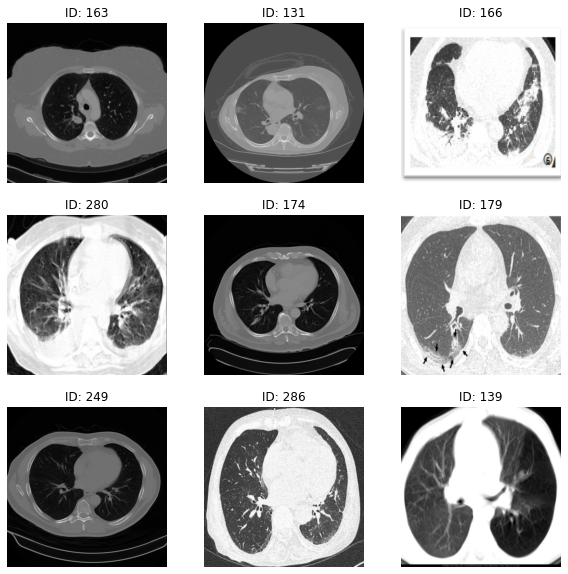

In [7]:
# Test Data
plt.figure(figsize=(10, 10))
for i, ds in enumerate(test_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(ds['image'].numpy().astype("uint8"))
    plt.title('ID: {}'.format(ds['id'].numpy()))
    plt.axis("off")

### Configure the dataset for performance

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE[0], IMG_SIZE[1], interpolation='bilinear'),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
])

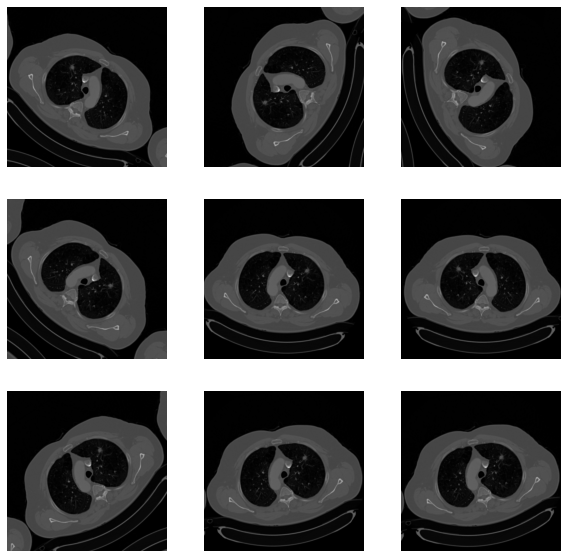

In [9]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Model

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [10]:
# Data
# Model
# Train & Validate
    # k-fold
        # pre train
        # fine tune
        # re-train with entire ds
        # record accuracy and hyperparams
# Save Model
# Evaluate

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
base_model.summary()

xpand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 32, 32, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 32, 32, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 32, 32, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 32, 32, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 32, 32, 64)   256         block_6_project[0][

In [12]:
# Classification head
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 16, 16, 1280)
(32, 1280)
(32, 3)


In [13]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = resize_and_rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
initial_epochs = 200
fine_tune_epochs = 100
learning_rate = 1e-4
label_smoothing = 0.1

tf.keras.backend.clear_session()
tf.random.set_seed(SEED)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

# Train and Validate

In [15]:
# loss0, accuracy0 = model.evaluate(valid_ds)
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

In [16]:
tf.random.set_seed(SEED)

history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=valid_ds
)

 val_accuracy: 0.8966
Epoch 62/200
33/33 [==============================] - 2s 66ms/step - loss: 0.5170 - accuracy: 0.8702 - val_loss: 0.5002 - val_accuracy: 0.8966
Epoch 63/200
33/33 [==============================] - 2s 67ms/step - loss: 0.5011 - accuracy: 0.8931 - val_loss: 0.5001 - val_accuracy: 0.8966
Epoch 64/200
33/33 [==============================] - 2s 66ms/step - loss: 0.5042 - accuracy: 0.8884 - val_loss: 0.4987 - val_accuracy: 0.8966
Epoch 65/200
33/33 [==============================] - 2s 67ms/step - loss: 0.5094 - accuracy: 0.8807 - val_loss: 0.4982 - val_accuracy: 0.8966
Epoch 66/200
33/33 [==============================] - 2s 68ms/step - loss: 0.5070 - accuracy: 0.8884 - val_loss: 0.4983 - val_accuracy: 0.8966
Epoch 67/200
33/33 [==============================] - 2s 67ms/step - loss: 0.5095 - accuracy: 0.8760 - val_loss: 0.4984 - val_accuracy: 0.8966
Epoch 68/200
33/33 [==============================] - 2s 68ms/step - loss: 0.5119 - accuracy: 0.8740 - val_loss: 0.4967 

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

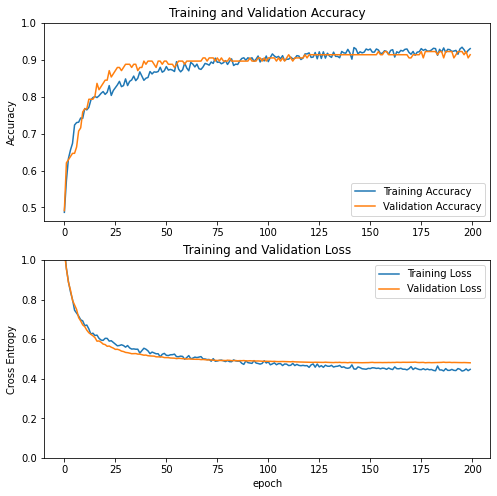

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [18]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [19]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate / 10),
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [20]:
tf.random.set_seed(SEED)

total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=valid_ds
)

Epoch 200/300
33/33 [==============================] - 4s 110ms/step - loss: 0.4663 - accuracy: 0.9113 - val_loss: 0.4945 - val_accuracy: 0.9052
Epoch 201/300
33/33 [==============================] - 3s 92ms/step - loss: 0.4373 - accuracy: 0.9437 - val_loss: 0.5028 - val_accuracy: 0.8879
Epoch 202/300
33/33 [==============================] - 3s 97ms/step - loss: 0.4345 - accuracy: 0.9265 - val_loss: 0.4841 - val_accuracy: 0.8879
Epoch 203/300
33/33 [==============================] - 3s 97ms/step - loss: 0.4255 - accuracy: 0.9418 - val_loss: 0.4937 - val_accuracy: 0.8966
Epoch 204/300
33/33 [==============================] - 3s 96ms/step - loss: 0.4148 - accuracy: 0.9456 - val_loss: 0.4962 - val_accuracy: 0.8879
Epoch 205/300
33/33 [==============================] - 3s 98ms/step - loss: 0.4158 - accuracy: 0.9418 - val_loss: 0.4961 - val_accuracy: 0.8966
Epoch 206/300
33/33 [==============================] - 3s 99ms/step - loss: 0.4083 - accuracy: 0.9532 - val_loss: 0.4742 - val_accuracy

After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

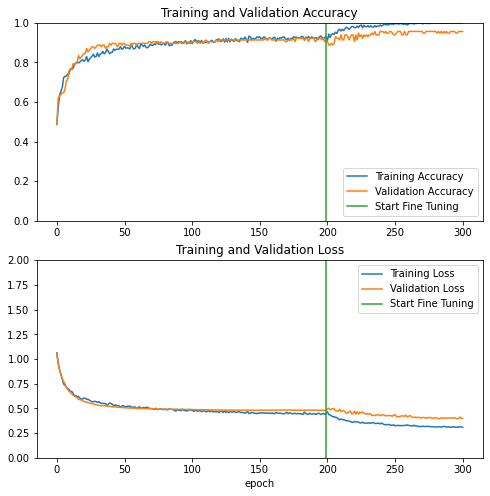

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Prediction

In [23]:
tf.random.set_seed(SEED)

# TODO: combine ds and retrain

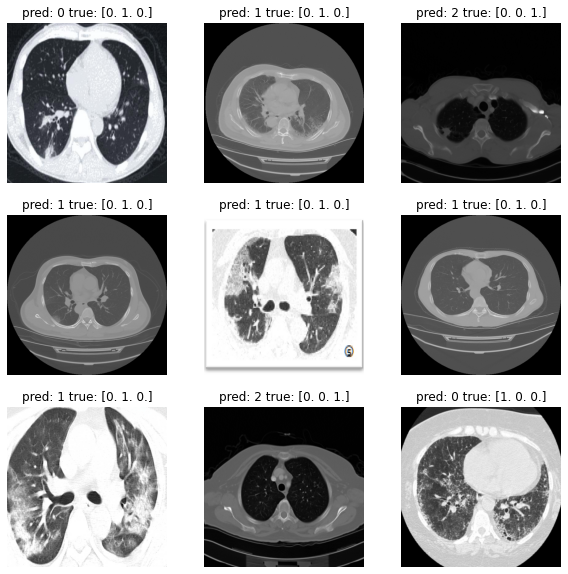

In [24]:
image_batch, label_batch = valid_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_indices = tf.argmax(predictions, 1)
predicted_labels = predicted_indices.numpy()


plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f'pred: {predicted_labels[i]} true: {label_batch[i]}')
  plt.axis("off")

# Evaluate

In [25]:
ds = test_ds.map(lambda ds: (ds['image'], ds['label'])).batch(TEST_BATCH_SIZE)
predictions = model.predict(ds)
predicted_indices = tf.argmax(predictions, 1)
predicted_labels = predicted_indices.numpy()
predicted_labels

array([2, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1,
       1, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       2, 1, 2, 0, 2, 0, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1, 0, 2, 1,
       1, 0, 1, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1,
       1, 0, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 0, 1, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 1, 2, 1, 1, 0, 2, 1, 1, 0,
       0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 2,
       1, 0, 1, 0, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1, 0, 2, 1, 0, 0,
       2, 1, 1, 0, 1, 1, 2, 2, 1, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1, 2,
       0, 1, 2, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       2, 1, 0, 0, 1, 0, 1, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 2,
       1, 2, 1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 0, 1, 1, 1, 2, 2, 1, 2, 0, 1,
       0, 2, 0, 1, 1, 1])

In [26]:
def save_results(save_path, image_ids, predicted_labels):
    results = image_ids.drop('image', axis=1)
    results.columns = ['ID', 'Label']
    results['Label'] = predicted_labels 
    results = results.sort_values('ID').reset_index(drop=True)
    results.to_csv(RESULT_SAVE_PATH, index=False)


RESULT_SAVE_PATH = 'submission.csv'

img_ids = tfds.as_dataframe(test_ds, test_info)
save_results(RESULT_SAVE_PATH, img_ids, predicted_labels)